# NER by transformer

In [2]:
!nvidia-smi

Mon Aug  7 14:59:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   32C    P8     7W / 198W |      2MiB /  8119MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:17:00.0 Off |                  N/A |
|  0%   

In [ ]:
#!pip install torch
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_sequence
import torch.nn.functional as F
import math
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

## Load Data

### **CoNLL-2003 NER Dataset**
包含四種named entities的標註資料，分別是***人名(persons)***、***地名(locations)***、***組織名(organizations)***、***其他名稱(miscellaneous)***。  
資料集格式為(word、POS tag、syntactic chunk tag、BIO tag)  
此處使用處理過的資料，只留下word和BIO tag。
BIO tagging是指把named entities token分為Begin、Inside、Outside，範例如下:

Contains annotation data for four named entities, namely persons, locations, organizations, and miscellaneous.
The data set format is (word, POS tag, syntactic chunk tag, BIO tag)
The processed data is used here, leaving only word and BIO tag.
BIO tagging refers to dividing named entities tokens into Begin, Inside, and Outside. Examples are as follows:

Tom ***B-PER***  
cruise ***I-PER***  
is ***O***  
an ***O***  
American ***B-LOC***  
actor ***O***  
and ***O***  
producer ***O***  
. ***O***  

### 讀入CoNLL-2003 dataset的三個檔案(train, valid, test)

In [ ]:
# 資料集在自己google drive底下的路徑
train_path = 'CoNLL2003_Data/train.txt' # 用來訓練的資料
eval_path = 'CoNLL2003_Data/eval.txt' # 有時候在資料集當中會叫valid，但意思都是拿來驗證的資料，用來判斷模型是否出現過擬合。
test_path = 'CoNLL2003_Data/test.txt' # 要預測的資料


先看看檔案前13行的樣子

In [ ]:
with open(train_path) as f:
    print(f.readlines()[:13])

dataset由"-DOCSTART- O\n"開始，後面接續著幾句話，每句話由換行("\n")隔開

第一句話是:
"EU rejects German call to boycott British lamb."

標籤是:
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

接下來請將資料整理為List[List[str]]，用一個List存放所有句子，每個句子都是一個List，
input和output一對一對應。  

整理後範例結果:
* **Input**  
[['-DOCSTART-'], ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], ['Peter', 'Blackburn']]  
* **Output**  
[['O'], ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'], ['B-PER', 'I-PER']]  



#### 在以下cell中撰寫讀檔function (約30行內)
* 輸入: 檔案路徑  
* 輸出: 兩個List，shape皆為List[List[str]]，分別存放資料輸入、輸出。  


*提示*  
* `open(file_path)`
* `w, t = line.split()` 取得詞(w)和BIO tagging答案(t)
* split的相關用法: `print(str.split.__doc__)`

In [4]:
from tqdm import tqdm
def data_loader(file_path):
    words, targets = [], []
    word_sentence, target_sentence = [], []
    with open(file_path, 'r', encoding='UTF-8') as file:
        for line in tqdm(file):
            if line !="\n":
                w, t = line.split()
                word_sentence.append(w)
                target_sentence.append(t)
            else:
                words.append(word_sentence)
                targets.append(target_sentence)
                word_sentence, target_sentence = [], []
    return words, targets

讀檔並看看結果是否符合預期

In [ ]:
train_words, train_targets = data_loader(train_path)
eval_words, eval_targets = data_loader(eval_path)
test_words, _ = data_loader(test_path)

print(train_words[:5])
print(train_targets[:5])

### 使用gensim訓練Word2Vec (2行)
訓練並儲存模型，下次執行時只需要load就好。  

*使用到的變數*
* train_words
* word_emb_dim

*要產生的變數*
* embedding_model

*提示*  
* Word2Vec min_count設為1  
* `.save(output_path + 'word_embedding_model')`
* https://radimrehurek.com/gensim/models/word2vec.html

In [6]:
word_emb_dim = 128 # 與後面的d_model參數需一致

In [ ]:
output_path = "output/"
embedding_model =  Word2Vec(sentences=train_words, vector_size=word_emb_dim, window=5, min_count=1, workers=4)# 訓練word2vec模型
embedding_model.save(output_path + 'word_embedding_model')# 儲存模型
embedding_model = Word2Vec.load(output_path + '/word_embedding_model')

### 使用embedding_model建立vocabulary，並在vocab的index 0位置加入**\<PAD\>**、index 1加入**\<UNK\>**。(4行)  
通常\<PAD\>建議編號為0，因為大多數處理padding的function中都是預設輸入值為0時是代表padding，  
\<UNK\>則沒有限制(但通常放1或最後)  

*使用到的變數*
* word_emb_dim
* embedding_model

*要產生的變數*
* word_embedding: List[List[float]]，傳入index可以取得該index的embedding
* vocab: List[str]，傳入index可以取得該index的字串
* vocab_size: vocab中有多少字(包括\<PAD\>、\<UNK\>

*提示*  
* `list(embedding_model.wv.key_to_index.keys())` => 所有word照順序排的list
* `embedding_model.wv[embedding_word].tolist()` => 所有embedding照順序排的list
* `[[0.] * word_emb_dim]` => 產生一個list，裡面有word_emb_dim個0.
* `A_list = [1, 2, 3]`  
`B_list = [4, 5, 6]`  
`A_list + B_list = [1, 2, 3, 4, 5, 6]`

In [9]:
word_embedding = [[0.5] * word_emb_dim] + embedding_model.wv.vectors.tolist() # 將<UNK>的vector設為全部0.5的向量並加入embedding list的最前面
word_embedding = [[0.] * word_emb_dim] +  word_embedding# 將<PAD>的vector設為全部0.的向量並加入embedding list的最前面

vocab = ["<PAD>"] + ["<UNK>"] + list(embedding_model.wv.key_to_index.keys())
vocab_size = len(vocab)

In [10]:
print(len(word_embedding)); len(vocab)

23626


23626

### 建立文字和index互換的list、dictionary (約2行)

*使用到的變數*
* vocab

*要產生的變數*
* word2idx
* tag2idx

*提示*
* 文字轉index是dictionary，可用單行for配上`enumerate(vocab)`建字典

In [11]:
idx2word = vocab
word2idx = {word: idx for idx, word in enumerate(vocab)}

idx2tag = ['<PAD>', 'O', 'B-LOC', 'B-PER', 'B-ORG', 'B-MISC', 'I-LOC', 'I-PER', 'I-ORG', 'I-MISC']
tag2idx = {tag: idx for idx, tag in  enumerate(idx2tag)}

### 將train、eval、test都轉為數字表示。  
如果不在vocabulary中，則把word用\<UNK\>代替。  


`["A" if 條件式 else "B" for item in list]`  

等價於  

    temp_list = []  
    for item in list:  
      if 條件式:  
        temp_list.append("A")  
      else:  
        temp_list.append("B")  
    return temp_list

In [12]:
train_words_as_int = [[word2idx['<UNK>'] if word not in word2idx else word2idx[word] for word in sentence] for sentence in train_words]
train_targets_as_int = [[tag2idx[tag] for tag in sentence] for sentence in train_targets]

eval_words_as_int = [[word2idx['<UNK>'] if word not in word2idx else word2idx[word] for word in sentence] for sentence in eval_words]
eval_targets_as_int = [[tag2idx[tag] for tag in sentence] for sentence in eval_targets]

test_words_as_int = [[word2idx['<UNK>'] if word not in word2idx else word2idx[word] for word in sentence] for sentence in test_words]

### Create dataset

定義資料集的BATCH_SIZE

In [13]:
BATCH_SIZE = 64

In [14]:
class CoNLLDataset(Dataset):
    def __init__(self, words, targets=None):
        self.words = words
        self.targets = targets

    def __getitem__(self, index):
        if self.targets == None:
            return torch.Tensor(self.words[index]).long()
        return torch.Tensor(self.words[index]).long(), torch.Tensor(self.targets[index]).long()

    def __len__(self):
        return len(self.words)

In [15]:
def PadCollate(batch):
    if type(batch[0]) is tuple: #train, evaluate
        x = [t for t, _ in batch]
        y = [t for _, t in batch]
        x = torch.nn.utils.rnn.pad_sequence(x, batch_first=True)
        y = torch.nn.utils.rnn.pad_sequence(y, batch_first=True)
        return x, y
    else: #test
        x = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True)
        return x

### 由list建立資料集 (3行)  
建立好的資料集輸出應為<torch.utils.data.dataloader.DataLoader object at ...>

*使用到的變數*  
* train_words_as_int
* train_targets_as_int
* BATCH_SIZE

*提示*  
* `CoNLLDataset` (傳入train_words_as_int和train_targets_as_int)  

* `DataLoader` (傳入dataset、BATCH_SIZE、選擇要shuffle、collate_fn使用PadCollate)  
num_workers是多執行緒讀取dataset，預設0但可以開1~4感受看看

In [16]:
train_dataset = CoNLLDataset(train_words_as_int, train_targets_as_int)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle = True, collate_fn = PadCollate)
print(train_loader)

和train_dataset一樣的code，輸入換成eval_words_as_int和eval_targets_as_int而已

*使用到的變數*
* eval_words_as_int
* eval_targets_as_int
* BATCH_SIZE



In [17]:
eval_dataset = CoNLLDataset(eval_words_as_int, eval_targets_as_int)
eval_loader = DataLoader(eval_dataset, BATCH_SIZE, shuffle = True, collate_fn = PadCollate)

同上，但Test dataset只有輸入沒有答案，並且為了之後要輸出，dataset不能洗亂  

*使用到的變數*
* test_words_as_int
* BATCH_SIZE

*提示*
* 要修改`CoNLLDataset`的傳入值 (少掉targets)
* 不要shuffle

In [18]:
test_dataset = CoNLLDataset(test_words_as_int)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle = True, collate_fn = PadCollate)

輸出dataset前三筆，看是否padding成功。

In [19]:
i = 0
for (inp, tar) in enumerate(train_loader):
    i += 1
    print(inp)
    print(tar)
    print('===================================')
    if i > 3:
        break

0
(tensor([[ 1091,    56,   106,  ...,     0,     0,     0],
        [11869,    23, 11862,  ...,     0,     0,     0],
        [   86,  1164,     5,  ...,     0,     0,     0],
        ...,
        [  109,  1387,     4,  ...,     0,     0,     0],
        [   22,     0,     0,  ...,     0,     0,     0],
        [ 2032,  2958,  3117,  ...,     0,     0,     0]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [4, 1, 4,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [3, 1, 1,  ..., 0, 0, 0]]))
1
(tensor([[  348,   219,   672,  ...,     0,     0,     0],
        [   22,     0,     0,  ...,     0,     0,     0],
        [   86, 12261,  2699,  ...,     0,     0,     0],
        ...,
        [10748,    78, 10746,  ...,     0,     0,     0],
        [   22,     0,     0,  ...,     0,     0,     0],
        [  323,   449,  4936,  ...,     0,     0,     0]]), tensor([[4, 1, 1,  ..., 0, 0, 0],
        [1, 0, 

## Tranformer Model

### Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence.

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [20]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [21]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

#   return tf.cast(pos_encoding, dtype=tf.float32)
  return pos_encoding

(1, 50, 512)


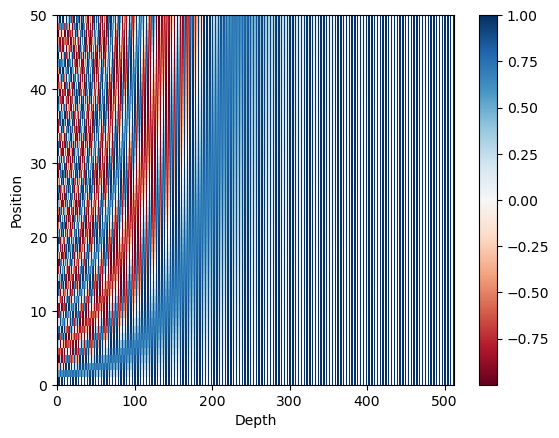

In [22]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Masking  
為了傳入self-attention，把資料中padding的部分(值為0)標為0.，其他的標為1.

In [23]:
def create_padding_mask(seq):
  seq = seq.bool().float()

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, None, None, :]  # (batch_size, 1, 1, seq_len)

In [24]:
x = torch.Tensor([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

tensor([[[[1., 1., 0., 0., 1.]]],


        [[[1., 1., 1., 0., 0.]]],


        [[[0., 0., 0., 1., 1.]]]])

### Scaled dot product attention (約10行)


<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax.

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

輸入q、k、v，算出所有output  

*提示*
* `torch.matmul` 算q跟k相乘 (k要transpose)
* `.size`取得k的最後一個dimension
* 把matmul_qk 除以 ${\sqrt{d_k}}$ (用`math.sqrt` 算)
* mask若不是None，把${\frac{QK^T}{\sqrt{d_k}}}$結果中被mask的位置變成-1e9，來使softmax後的值趨近於0，  
(mask變數中，被mask的值為0，使用`scaled_attention_logits.masked_fill(mask == X, Y)`，  
若mask中的值為X，就把scaled_attention_logits同樣位置的值換為Y)
* `F.softmax` 得到attention的值
* `torch.matmul` 把attention和V相乘


In [25]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """



  matmul_qk =  torch.matmul(q, k.transpose(-2, -1)) # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = k.size(-1)
  scaled_attention_logits = matmul_qk / math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits = scaled_attention_logits.masked_fill(mask == 0, -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights =  F.softmax(scaled_attention_logits, dim=-1) # (..., seq_len_q, seq_len_k)

  output = torch.matmul(attention_weights, v)# (..., seq_len_q, depth_v)

  return output, attention_weights

測試是否能執行，輸出應為  
tensor([[1.0000e+01, 9.2766e-25]])  
tensor([[8.4333e-26, 1.0000e+00, 8.4333e-26, 8.4333e-26]])

In [ ]:
temp_k = torch.tensor([[10,0,0],
            [0,10,0],
            [0,0,10],
            [0,0,10]], dtype=torch.float32).to(device)  # (4, 3)

temp_v = torch.tensor([[   1,0],
            [  10,0],
            [ 100,5],
            [1000,6]], dtype=torch.float32).to(device)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = torch.tensor([[0, 10, 0]], dtype=torch.float32).to(device)  # (1, 3)

temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_out)
print(temp_attn)

NameError: name 'torch' is not defined

### Multi-head attention (約30行)

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads.

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `.transpose`, and `.view`) and put through a final `Linear` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

*提示*  
* 總共四個`nn.Linear`，分別代表${W_q W_k W_v W_o}$
* Multi-head使用`.view`和`.transpose`完成
* forward() function流程
 * 取得batch_size
 * 將輸入的q、k、v經過Linear layer，得到要計算attention的q、k、v  
 `q = self.Wq(q)`
 * `split_heads` (需用到batch_size)
 * `scaled_dot_product_attention` (記得輸入mask)
 * 用`.transpose().contiguous()`和`.view`把`scaled_attention`的shape變回來   
 再用`self.Wo`把multi-head attention的結果合併

In [27]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads

    assert d_model % num_heads == 0

    self.depth = d_model // num_heads

    self.wq = nn.Linear(d_model, d_model)
    self.wk = nn.Linear(d_model, d_model)
    self.wv = nn.Linear(d_model, d_model)
    self.wo = nn.Linear(d_model, d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = x.view(batch_size, -1, self.num_heads, self.depth)
    return x.transpose(1, 2)

  def forward(self, q, k, v, mask):
    batch_size = q.size(0)
    d_model = q.size(2)

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

    scaled_attention = scaled_attention.transpose(1, 2).contiguous()  # (batch_size, seq_len_q, num_heads, depth)
    
    concat_attention = scaled_attention.view(batch_size, -1, d_model)  # (batch_size, seq_len_q, d_model)

    output = self.wo(concat_attention) # (batch_size, seq_len_q, d_model)

    return output, attention_weights

測試MultiHeadAttention layer是否可執行  
(torch.Size([1, 60, 512]), torch.Size([1, 8, 60, 60]))

In [28]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8).to(device)
y = torch.rand((1, 60, 512)).to(device)  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(v=y, k=y, q=y, mask=None)
out.shape, attn.shape

(torch.Size([1, 60, 512]), torch.Size([1, 8, 60, 60]))

### Point wise feed forward network (1~5行)

*提示*  
* 使用`nn.Sequential()`完成
* 兩層`nn.Linear`
* 中間夾一層`nn.ReLU()`


In [29]:
def point_wise_feed_forward_network(d_model, dff):
    return nn.Sequential(
        nn.Linear(d_model, dff) , # (batch_size, seq_len, dff)
        nn.ReLU(),
        nn.Linear(dff, d_model)  # (batch_size, seq_len, d_model)
    )

測試shape是否符合預期  
torch.Size([64, 50, 1024])

In [30]:
sample_ffn = point_wise_feed_forward_network(1024, 2048)
sample_ffn(torch.rand((64, 50, 1024))).shape

torch.Size([64, 50, 1024])

### Encoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="450" alt="transformer">  
因為這次的task是Sequence Tagging中的NER，只需要對每個token的embedding做classification，  
所以只需要使用到Encoder即可，  
以下先實作灰色框起來的encoder layer，  
再把N個encoder layer疊起來，加上embedding和positional encoding得到完整的Encoder

Layer Normalization: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

In [31]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

#### Encoder layer (約12行)  

繼承`nn.Module`

*提示*  
* \__init__\() (6行)
 * `MultiHeadAttention`
 * `point_wise_feed_forward_network`
 * `LayerNorm` 兩層 (傳入d_model)
 * `nn.Dropout` 兩層 (傳入rate)
* forward() (6行)
 * 把x和mask丟入`MultiHeadAttention`，此處的q、k、v都是x
 * 將attention丟進dropout1
 * dropout後的結果再進行layer normalization和residual connection，  
 也就是輸入進layernorm1中的是 (x + attn_output)

 * feed forward layer
 * 再dropout一次
 * 再進行layer normalization一次，注意是把第一次layer normalization的結果(out1)加上第二次dropout的結果(ffn_output)

In [32]:
class EncoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = LayerNorm(d_model)
    self.layernorm2 = LayerNorm(d_model)

    self.dropout1 = nn.Dropout(rate)
    self.dropout2 = nn.Dropout(rate)

  def forward(self, x, mask):
    x = x.float()
    attn_output, _ = self.mha(v=x, k=x, q=x, mask=mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output)
    out2 = self.layernorm1(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

Dropout指的是在模型訓練時初始化一定比例的layer的參數，同時會按1/(1-p)的比例縮放其餘參數，可以有效防止overfitting，但只能在training的時候使用，預測時需要忽略，nn.Dropout會偵測模型的狀態`model.train()` or `model.eval()`決定是否使用Dropout

對[1,1,1,1]進行dropout(0.5)後有可能會變成[2,2,0,0],[2,0,0,0],[2,0,2,0],[2,2,2,0],[2,2,2,2]....等，因為每個index都有0.5的機會變成0，0.5的機會變成1*( 1/(1-0.5))

測試EncoderLayer  
torch.Size([64, 43, 512])

In [33]:
sample_encoder_layer = EncoderLayer(512, 8, 2048).to(device)

sample_encoder_layer_output = sample_encoder_layer(
    torch.rand((64, 43, 512)).to(device), None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

torch.Size([64, 43, 512])

#### Encoder (約13行)

繼承`nn.Module`  

*提示*
* \__init__\()
 * d_model和num_layers為輸入的參數
 * 使用前面訓練好的word embedding作為權重初始值，  
 `torch.FloatTensor(word_emb)`，  
 宣告embedding為`nn.Embedding.from_pretrained`並傳入初始值  

 * `positional_encoding` 傳入兩個參數

 * `nn.ModuleList([])`，用迴圈宣告出一個list放入，裡面總共有num_layers個EncoderLayer
 * `nn.Dropout`
* forward()
 * 取得input_seq_len，x的shape為(batch_size, input_seq_len)

 * 把x輸入進embedding layer
 * 把embedding的值乘上${\sqrt{d_k}}$ (已完成)
 * 加上position_encoding，從(batch_size, maximum_position_encoding, d_model)中，  
 取前seq_len個encoding並和embedding相加 (已完成)
 * dropout
 * 從enc_layers[0]開始，把x一層層傳進所有encoder layer中，  
 每層都會輸出新的x，總共有self.num_layers個，最後的x就是最後一層encoder layer的輸出

In [34]:
class Encoder(nn.Module):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, word_emb, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.word_emb = torch.FloatTensor(word_emb)
    self.embedding = nn.Embedding.from_pretrained(self.word_emb)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)


    self.enc_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)])

    self.dropout = nn.Dropout(rate)

  def forward(self, x, mask):
    # x: (batch_size, input_seq_len)
    seq_len = x.size(1)

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)

    x *= math.sqrt(self.d_model)
    x = (x.cpu() + self.pos_encoding[:, :seq_len, :]).to(device)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, mask) 

    return x  # (batch_size, input_seq_len, d_model)

測試Encoder  
torch.Size([64, 62, 128])

In [35]:
sample_encoder = Encoder(num_layers=2, d_model=128, num_heads=8,
                         dff=2048, input_vocab_size=vocab_size,
                         maximum_position_encoding=10000, word_emb=word_embedding).to(device)

temp_input = torch.randint(size=(64, 62), low=0, high=200, dtype=torch.int64).to(device)

sample_encoder_output = sample_encoder(temp_input, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

torch.Size([64, 62, 128])


### Transformer (4行)

繼承`nn.Module`，把剛剛的encoder layer再接上最外層的Linear layer即可

*提示*  
* 使用輸入的參數在\__init__\()中宣告Encoder和`nn.Linear` (2行)
* forward() function中把輸入丟到encoder後再經過Dense layer就可輸出了 (2行)

In [36]:
class TaggingTransformer(nn.Module):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               label_size, pe_input, word_emb, rate=0.1):
    super(TaggingTransformer, self).__init__()

    self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads,
                           dff=dff, input_vocab_size=input_vocab_size,
                           maximum_position_encoding=pe_input, word_emb=word_emb)

    self.final_layer = nn.Linear(d_model, label_size)

  def forward(self, inp, enc_padding_mask):

    enc_output = self.encoder(inp, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    final_output = self.final_layer(enc_output)  # (batch_size, tar_seq_len, label_size)

    return final_output

測試Transformer  
torch.Size([64, 38, 10])

In [37]:
sample_transformer = TaggingTransformer(
    num_layers=2, d_model=128, num_heads=8, dff=2048,
    input_vocab_size=vocab_size, label_size=10,
    pe_input=10000, word_emb=word_embedding).to(device)

temp_input = torch.randint(size=(64, 38), dtype=torch.int64, low=0, high=200).to(device)

fn_out = sample_transformer(temp_input, enc_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, label_size)

torch.Size([64, 38, 10])

### Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced.

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [38]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = vocab_size
label_size = 10
dropout_rate = 0.1

## Loss and metrics (1行)

*提示*  
* 使用`nn.CrossEntropyLoss`，ignore_index來把值為0的都忽略


In [39]:
loss_object = nn.CrossEntropyLoss(ignore_index=0)

## Training and checkpointing

到這裡才真正使用參數建立出Transformer model

In [40]:
transformer = TaggingTransformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, label_size,
                          pe_input=input_vocab_size,
                          word_emb=word_embedding,
                          rate=dropout_rate).to(device)

## Optimizer (1行)

使用`torch.optim.Adam`，傳入模型所有可訓練的weight (`.parameters()`) 和learning_rate

In [41]:
learning_rate = 0.001

optimizer = torch.optim.Adam(transformer.parameters(), learning_rate)

In [42]:
EPOCHS = 20

### 設定evaluate function

在每個epoch結束後，用eval資料來評估整個模型是否overfitting  
*提示*  
* predictions是transformer的預測結果
* loss是前面定義的loss_object，注意predictions輸入時的shape要是(batch_size, label_size, seq_len)

In [43]:
def evaluate(eval_loader, model, loss_object):
  model.eval()

  with torch.no_grad():

    running_loss = 0.0
    correct = 0
    total = 0

    for (batch, (inp, tar)) in enumerate(eval_loader):
      inp = inp.to(device)
      tar = tar.to(device)
      enc_padding_mask = create_padding_mask(inp).to(device)

      # predictions.shape == (batch_size, seq_len, label_size)
      predictions = transformer(inp, enc_padding_mask)

      _, predictions_id = torch.max(predictions, -1)

      predictions_id *= tar.bool().long()

      correct += (predictions_id == tar).sum().item() - (tar == 0).sum().item()
      total += (tar != 0).sum().item()

      loss = loss_object(predictions.transpose(1, 2), tar)

      running_loss += loss.item()

    print('Evaluate loss: {:.4f} acc: {:.4f}%\n'.format(running_loss / len(eval_loader), 100 * correct / total))

### 設定train_step (約7行)

*提示*  
* 在每個batch中
 * 初始化optimizer (`.zero_grad()`)
 * 預測答案(transformer)得到predictions
* `loss_object`輸入predictions和target算出loss，注意predictions的shape要是(batch_size, label_size, seq_len)
* `.backward()`反向傳播
* `.step()` 更新模型

跑EPOCHS個epoch  

每5個epoch存一次checkpoint

In [44]:
for epoch in range(EPOCHS):  # loop over the dataset multiple times
  start = time.time()

  running_loss = 0.0

  transformer.train()

  for (batch, (inp, tar)) in enumerate(train_loader):
    inp = inp.to(device)
    tar = tar.to(device)
    enc_padding_mask = create_padding_mask(inp).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    predictions = transformer(inp, enc_padding_mask)

    loss = loss_object(predictions.transpose(1, 2), tar)

    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if batch % 50 == 0 and batch != 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(
          epoch + 1, batch, running_loss / 50))
      running_loss = 0.0

  if (epoch + 1) % 5 == 0:
    torch.save(transformer.state_dict(), output_path + '/checkpoint_{}'.format(epoch + 1))
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, output_path + '/checkpoint_{}'.format(epoch + 1)))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

  evaluate(eval_loader, transformer, loss_object)

print('Finished Training')

Epoch 1 Batch 50 Loss 0.7283
Epoch 1 Batch 100 Loss 0.5844
Epoch 1 Batch 150 Loss 0.5531
Epoch 1 Batch 200 Loss 0.5574
Time taken for 1 epoch: 7.440134525299072 secs

Evaluate loss: 0.5726 acc: 85.0816%

Epoch 2 Batch 50 Loss 0.5364
Epoch 2 Batch 100 Loss 0.5341
Epoch 2 Batch 150 Loss 0.5188
Epoch 2 Batch 200 Loss 0.5100
Time taken for 1 epoch: 7.323398113250732 secs

Evaluate loss: 0.5467 acc: 85.3027%

Epoch 3 Batch 50 Loss 0.5284
Epoch 3 Batch 100 Loss 0.4922
Epoch 3 Batch 150 Loss 0.4855
Epoch 3 Batch 200 Loss 0.4761
Time taken for 1 epoch: 7.356501817703247 secs

Evaluate loss: 0.5386 acc: 85.3473%

Epoch 4 Batch 50 Loss 0.5026
Epoch 4 Batch 100 Loss 0.4740
Epoch 4 Batch 150 Loss 0.4704
Epoch 4 Batch 200 Loss 0.4637
Time taken for 1 epoch: 7.242371082305908 secs

Evaluate loss: 0.5441 acc: 85.5470%

Epoch 5 Batch 50 Loss 0.4756
Epoch 5 Batch 100 Loss 0.4696
Epoch 5 Batch 150 Loss 0.4572
Epoch 5 Batch 200 Loss 0.4558
Saving checkpoint for epoch 5 at output//checkpoint_5
Time taken 

## Predicting on test data (3行)

在訓練完之後，預測在test data上，  
因為沒有答案也不用算accuracy，只需要處理padding部分的輸出，  
把input中padding的部分用資料型態轉換得出，再和預測的輸出相乘，(不推薦)  
最後reshape成一維後，用一個list放所有的結果

*提示*  
* 預測答案
* `torch.max` 回傳指定dim中最大的位置
* 把inp轉bool再轉int

In [50]:
def predict(test_loader, model):
  result = []

  for (batch, (inp)) in enumerate(test_loader):
    enc_padding_mask = create_padding_mask(inp).to(device)
    inp = inp.to(device)

    # predictions.shape == (batch_size, seq_len, label_size)
    predictions = transformer(inp, enc_padding_mask)

    _, predicted_id = torch.max(predictions, -1)
    
    predicted_id *= inp.bool().long()             #tar.bool().long()

    result += predicted_id.view(-1).cpu().numpy().tolist()
  return result

如果預測結果中有0代表是padding，就在把數字label轉換成文字時忽略掉。 (不推薦)

In [51]:
output_id = predict(test_loader, transformer)
output_tag = [idx2tag[token] for token in output_id if token != 0]
print(output_tag[:20])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


根據格式，輸出到test_result中

In [52]:
output_position = 0
with open(output_path + '/test_result.txt', 'w') as f:
    for line in test_words:
        for word in line:
            f.write('{} {}\n'.format(word, output_tag[output_position]))
            output_position += 1
        f.write('\n')
